In [ ]:
import cv2
import os

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet50 import preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Conv2D, Dropout, Input
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.callbacks import TensorBoard, LearningRateScheduler, ModelCheckpoint
from keras.callbacks import EarlyStopping,ReduceLROnPlateau, LambdaCallback


## Data Augmentation

In [ ]:
"""
  The following code performs data augmentation to increase train size and also to
  add variance to the trained model

"""  

In [ ]:
def blur(img):
    return cv2.blur(img, (3,3))

In [ ]:
augmenter_blur = ImageDataGenerator(rotation_range = 30,
                               width_shift_range=0.2,
                               height_shift_range = 0.2,
                              shear_range = 0.2,
                              zoom_range=0.2,
                               horizontal_flip= True,
                              brightness_range= (1.0, 1.3),
                              preprocessing_function = blur)

In [ ]:
augmenter = ImageDataGenerator(rotation_range = 35,
                               width_shift_range=0.2,
                               height_shift_range = 0.2,
                              shear_range = 0.2,
                              zoom_range=0.3,
                               horizontal_flip= True,
                              brightness_range= (1.0, 1.3))

In [ ]:
i = 0
for batch in augmenter_blur.flow(keras_array, batch_size= 1,
                            save_format='jpeg', save_prefix='blur',
                            save_to_dir= 'Augmented',):
    i += 1
    if i>5:
        break
        

In [ ]:
PATH = os.getcwd()

In [ ]:
data_dir_list = os.listdir(PATH)

In [ ]:
len(data_dir_list)

In [ ]:
data_dir_list

In [ ]:
image_data_list = []
for image in data_dir_list:
    if image !='Untitled.ipynb':
        keras_img = load_img(image ,grayscale = False)
        image_array = img_to_array(keras_img)
        #image_array /= 255.0
        image_array = np.expand_dims(image_array, axis = 0)
        image_data_list.append(image_array)    

In [ ]:
len(image_data_list)

In [ ]:
for image in image_data_list:
    i = 0
    for batch in augmenter_blur.flow(image, batch_size= 1,
                                save_format='jpeg', save_prefix='blur',
                                save_to_dir= 'Augmented',):
        i += 1
        if i>5:
            break
            
    
    for batch in augmenter.flow(image, batch_size= 1,
                                save_format='jpeg', save_prefix='non_blur',
                                save_to_dir= 'Augmented'):
        i += 1
        if i>5:
            break   
        


## Load Data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd drive/

/content/drive


In [ ]:
cd My\ Drive

/content/drive/My Drive


In [ ]:
cd Face\ Training

/content/drive/My Drive/Face Training


In [ ]:
ls

Fake/             F.png  Me.png  Real.png            Training_data
Final_model_duh/  logs/  Real/   training_array.npy


In [ ]:
os.getcwd()

'/content/drive/My Drive/Face Training'

In [ ]:
DATA_DIR = os.getcwd()
CATEGORIES = ['Fake', 'Real']

In [ ]:
training_data = []
for category in CATEGORIES:

  PATH = os.path.join(os.getcwd(),category)
  images_list = os.listdir(PATH)
  target_class = CATEGORIES.index(category)

  for image in images_list:

    image_path = os.path.join(PATH,image)
    image = load_img(image_path, target_size = (224,224))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis = 0)
    image_array = preprocess_input(image_array)
    training_data.append([image_array, target_class])

In [ ]:

import random
random.shuffle(training_data)

In [ ]:
len(training_data)

15163

In [ ]:
X = []
y = []

In [ ]:
for features, labels in training_data:
  X.append(features)
  y.append(labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split((X), (y), test_size = 0.05, random_state = 42)

In [ ]:
# import pickle

# pickle_out = open("Training_data", "wb")
# pickle.dump(training_data, pickle_out)
# pickle_out.close()

In [ ]:
#training_array = np.save( 'training_array',np.array(training_data))

In [ ]:
(X_train)[5].shape

(1, 224, 224, 3)

In [ ]:
X_train = np.array(X_train)

In [ ]:
X_train = np.rollaxis(X_train, axis = 1)

In [ ]:
X_train = X_train.reshape((14404, 224, 224, 3))

In [ ]:
X_train.shape

(14404, 224, 224, 3)

## Model creation

In [ ]:
"""
We use a pre-trained Resnet50 model after trying out various other models like VGG16,
VGG19, Mobilenet etc..
Transfer Learning using imagenet weights

"""

In [ ]:
image_input = Input(shape=(224, 224, 3))

In [ ]:
resnet_model = ResNet50(weights = 'imagenet', include_top = False, input_tensor = image_input)

In [ ]:
#resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
last_layer = resnet_model.output

In [ ]:
x = GlobalAveragePooling2D()(last_layer)
x = Dense(512, activation='relu',name='fc_1')(x)
x =  Dense(256, activation='relu',name='fc_2')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation = 'sigmoid', name = 'output_layer')(x)

In [ ]:
custom_resnet_model = Model(inputs = image_input, outputs = output)

In [ ]:
custom_resnet_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
for layer in custom_resnet_model.layers[:-5]:
    layer.trainable = False

In [ ]:
custom_resnet_model.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
tb = TensorBoard(write_graph = True, 
                 write_images= False, 
                 histogram_freq= 1)

early_stopper = EarlyStopping(monitor = 'val_accuracy', 
                              patience= 4, 
                              mode = 'max', min_delta = 0.001, 
                              verbose = 1)

filepath = PATH
checkpoint = ModelCheckpoint(filepath = filepath,
                             monitor = 'val_accuracy',
                             save_best_only= True, 
                             verbose = 1)

lr_optimizer = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3,
                                 patience = 4, cooldown= 1,
                                 min_lr = 10e-7)


In [ ]:
hist = custom_resnet_model.fit((X_train), np.array(y_train), batch_size = 128, 
                           epochs = 100,
                           validation_split = 0.1,
                           callbacks = [tb, early_stopper, 
                                                   lr_optimizer])

Epoch 1/100
  1/102 [..............................] - ETA: 0s - loss: 0.6505 - accuracy: 0.6328WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
102/102 [==============================] - 26s 258ms/step - loss: 0.0552 - accuracy: 0.9799 - val_loss: 0.0122 - val_accuracy: 0.9965
Epoch 2/100
102/102 [==============================] - 24s 240ms/step - loss: 0.0072 - accuracy: 0.9977 - val_loss: 0.0069 - val_accuracy: 0.9986
Epoch 3/100
102/102 [==============================] - 24s 239ms/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.0074 - val_accuracy: 0.9979
Epoch 4/100
102/102 [==============================] - 24s 239ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.0074 - val_accuracy: 0.9972
Epoch 5/100
102/102 [==============================] -

In [ ]:
custom_resnet_model.save("Final_model_duh")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Final_model_duh/assets


In [ ]:
 pred= custom_resnet_model.predict(np.array(X_test).reshape(-1,224,224,3))

In [ ]:
from sklearn import metrics

In [ ]:
pred = pred>0.5

In [ ]:
metrics.accuracy_score(np.array(y_test), pred)

0.9960474308300395

# **For implementation run below cells**

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model('Final_model_duh')

In [ ]:
def prediction(path):
  image = load_img(path, target_size = (224,224) )
  image_array = img_to_array(image)
  image_array = np.expand_dims(image_array, axis = 0)
  image_array = preprocess_input(image_array)
  plt.imshow(image_array.reshape(224,224,3))
  #image_array = np.reshape(image_array, (224,224,3))
  
  probability = model.predict(image_array)
  print(probability)
  if probability>0.5:
    print("Real Profile. Accept")
  else:
    print("Fake Profile")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[1.]]
Real Profile. Accept


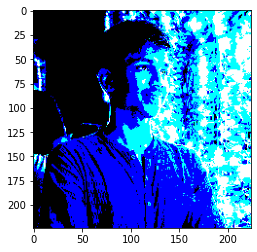

In [ ]:
prediction(path = 'Me.png')